# Computer Vision Coursework Submission (IN3060)

**Student name, ID and cohort:** Sykat Howlader (210018421) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset', 'Personal_Dataset', 'Models', 'Code', 'Copy of test_functions.ipynb', 'test_functions.ipynb']


In [3]:
#path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset','CV2024_CW_Dataset.zip' )

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

### Load packages

In the next cell you should load all the packages required to test your functions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from PIL import Image
from skimage import img_as_ubyte, io, color, filters, data, exposure
import cv2
import random
from skimage.feature import hog


In [5]:
# Function to load a selected number of images from the 'images' directory and their labels from text files in the 'labels' directory

def import_images_and_labels(root_path, num_images=4):
    images = []
    labels = []

    # Define paths to images and labels directories
    images_path = os.path.join(root_path, 'images')
    labels_path = os.path.join(root_path, 'labels')

    # Get list of image files
    image_files = [f for f in os.listdir(images_path) if f.endswith('.jpeg')]  # Adjust the extension as needed
    # Randomly shuffle the list of image files
    random.shuffle(image_files)

    # Load only num_images randomly selected images and their labels
    for image_file in image_files[:num_images]:
        # Read the image
        image_path = os.path.join(images_path, image_file)
        images.append(io.imread(image_path))

        # Read the corresponding label
        label_file = image_file.replace('.jpeg', '.txt')  # Ensure this matches your actual file naming scheme
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as file:
            label = file.read().strip()
            labels.append(int(label))

    return images, labels

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # Images are RGB

        self.conv1 = nn.Conv2d(3, 6, 5)  # Input: 3 (RGB), Output: 6 feature maps, Filter size: 5x5
        self.pool = nn.MaxPool2d(2, 2)   # Pooling layer: 2x2 window, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) # Input: 6, Output: 16, Filter size: 5x5


        # Fully connected layers:
        self.fc1 = nn.Linear(16 * 29 * 29, 120) # Input: 16*29*29, Output: 120
        self.fc2 = nn.Linear(120, 84)          # Input: 120, Output: 84


        # The final layer's output is 3, corresponding to the number of labels
        self.fc3 = nn.Linear(84, 3)            # For 3 classes: Not Wearing, Correctly Wearing, Improperly Wearing

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 -> ReLU -> pool
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 -> ReLU -> pool
        x = x.view(-1, 16 * 29 * 29)          # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))               # Apply fc1 -> ReLU
        x = F.relu(self.fc2(x))               # Apply fc2 -> ReLU
        x = self.fc3(x)                       # Apply fc3
        return x


class CustomDataset(Dataset):
    def __init__(self, root_path, transform=None, augment_transform=None):
        self.images, self.labels = import_images_and_labels(root_path)
        self.transform = transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # First, apply general transformation to all images
        if self.transform:
            image = self.transform(image)

        # Then, for class 2, apply additional augmented transformations
        if label == 2 and self.augment_transform is not None:
            image = transforms.ToPILImage()(image)  # Convert tensor back to PIL Image
            image = self.augment_transform(image)  # Now apply the augment_transform

        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)

        return image, label

from torchvision import transforms




In [7]:
#It's time to test on the test set of the data. First I need to load the images and labels and preprocess the images.

def preprocess_images(images, target_size=(128, 150)):
    preprocessed_images = []

    for img in images:
        # Resize the image
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # Convert the resized image to grayscale
        img_gray = color.rgb2gray(img_resized)

        # Apply histogram equalization
        img_hist_eq = exposure.equalize_hist(img_gray)

        # Apply sharpening filter
        img_sharp = filters.unsharp_mask(img_hist_eq, radius=1, amount=2)

        preprocessed_images.append(img_sharp)

    return preprocessed_images


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` to avoid having to reload them each time.

In [8]:
# Loading the HOG+SVM classifier
path_classifier = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'svm_classifier.joblib')
hog_svm = load(path_classifier)

In [9]:
#Loading the HOG+MLP classifier
path_classifier = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'mlp_classifier.joblib')
hog_mlp = load(path_classifier)

In [10]:
# Loading the CNN model

path =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn_classifier.pth')
net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [11]:
def MaskDetection(path_to_testset, model_type):
    # Label mapping
    label_mapping = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}

    if model_type in ["hog-svm", "hog-mlp", "cnn"]:
        # Load 4 images and labels
        images, labels = import_images_and_labels(path_to_testset, num_images=4)

        if model_type in ["hog-svm", "hog-mlp"]:
            # Preprocess the images
            X_preprocessed = preprocess_images(images, target_size=(128, 150))
            # Extract the HOG features
            X_test_hog = [hog(image, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=False, multichannel=False, feature_vector=True)
                          for image in X_preprocessed]
            if model_type == "hog-svm":
                predicted_labels = hog_svm.predict(X_test_hog)
            elif model_type == "hog-mlp":
                predicted_labels = hog_mlp.predict(X_test_hog)
        elif model_type == "cnn":

            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            X_preprocessed = [transform(image).unsqueeze(0) for image in images]
            predicted_labels = []
            for img in X_preprocessed:
                output = net(img)  # Forward pass
                _, predicted = torch.max(output, 1)
                predicted_labels.append(predicted.item())

        # Display the images with original and predicted labels
        fig, axes = plt.subplots(1, 4, figsize=(12, 6))
        for i, ax in enumerate(axes):
            ax.imshow(images[i], cmap='gray')  # Ensure these images are displayable
            original_text = label_mapping.get(labels[i], "Unknown")
            predicted_text = label_mapping.get(predicted_labels[i], "Unknown")
            ax.set_title(f"Original: {original_text}, Predicted: {predicted_text}", fontsize=10)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    else:
        print("Unsupported model type. Please provide one of the following methods: hog-svm, hog-mlp, cnn.")


Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

When calling the function, the possible model types that can be specified as parameters include:


*   hog-svm, for performing tests using the HOG+SVM model
*   hog-mlp, for performing tests using the HOG+MLP model
*   cnn, for performing tests using the CNN model








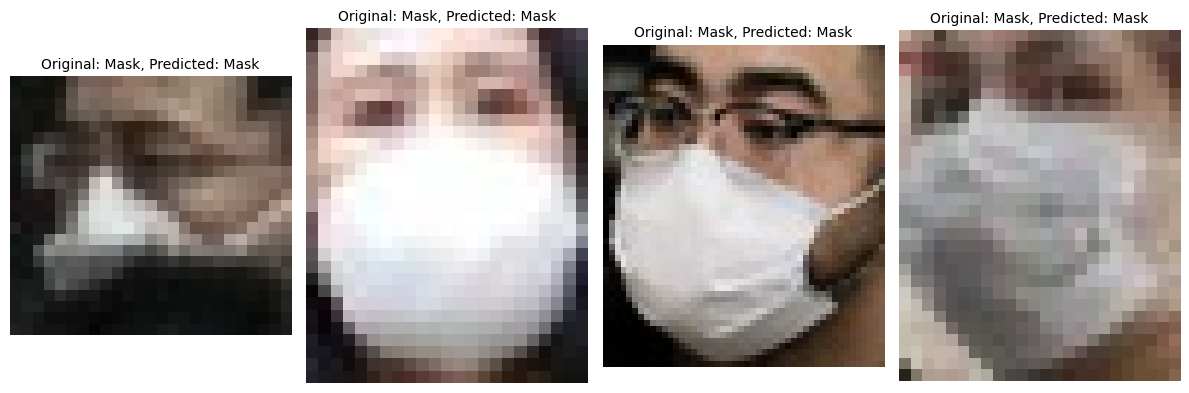

In [15]:
MaskDetection('test', 'cnn')

# Test MaskDetection in the wild

This section should allow a quick test of the `MaskDetection` on your `Personal_Dataset`.

In [16]:
#Function taken from tutorial of lecture 06 and adapted to only select 4 images
def import_selected_data(path, label_list=None, num_images=4):
    """Load a specified number of images randomly from available directories."""
    images = []
    labels = []

    # Gather all image files from the specified folders
    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    all_files = []
    for folder in folder_names:
        folder_path = os.path.join(path, folder)
        file_names = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]
        all_files.extend([(file, folder) for file in file_names])  # List of tuples (filepath, foldername)

    # Shuffle all files and select the first 'num_images' entries
    random.shuffle(all_files)
    selected_files = all_files[:num_images]

    # Load images and labels
    for file_path, folder in selected_files:
        images.append(io.imread(file_path))
        labels.append(folder)

    return images, labels

In [17]:
def MaskDetection(path_to_testset, model_type):
    # Label mapping
    label_mapping_test = {"no_mask": "No Mask", "wearing_mask": "Mask", "mask_wearing_improperly": "Improper Mask"}
    label_mapping = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}


    if model_type in ["hog-svm", "hog-mlp", "cnn"]:
        # Load 4 images and labels
        images, labels = import_selected_data(path_to_testset, num_images=4)

        if model_type in ["hog-svm", "hog-mlp"]:
            # Preprocess the images
            X_preprocessed = preprocess_images(images, target_size=(128, 150))
            # Extract the HOG features
            X_test_hog = [hog(image, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=False, multichannel=False, feature_vector=True)
                          for image in X_preprocessed]
            if model_type == "hog-svm":
                predicted_labels = hog_svm.predict(X_test_hog)
            elif model_type == "hog-mlp":
                predicted_labels = hog_mlp.predict(X_test_hog)
        elif model_type == "cnn":
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            X_preprocessed = [transform(image).unsqueeze(0) for image in images]
            predicted_labels = []
            for img in X_preprocessed:
                output = net(img)  # Forward pass
                _, predicted = torch.max(output, 1)
                predicted_labels.append(predicted.item())

        # Display the images with original and predicted labels
        fig, axes = plt.subplots(1, 4, figsize=(12, 6))
        for i, ax in enumerate(axes):
            ax.imshow(images[i], cmap='gray')  # Ensure these images are displayable
            original_text = label_mapping_test.get(labels[i], "Unknown")
            predicted_text = label_mapping.get(predicted_labels[i], "Unknown")
            ax.set_title(f"Original: {original_text}, Predicted: {predicted_text}", fontsize=10)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    else:
        print("Unsupported model type. Please provide one of the following methods: hog-svm, hog-mlp, cnn.")

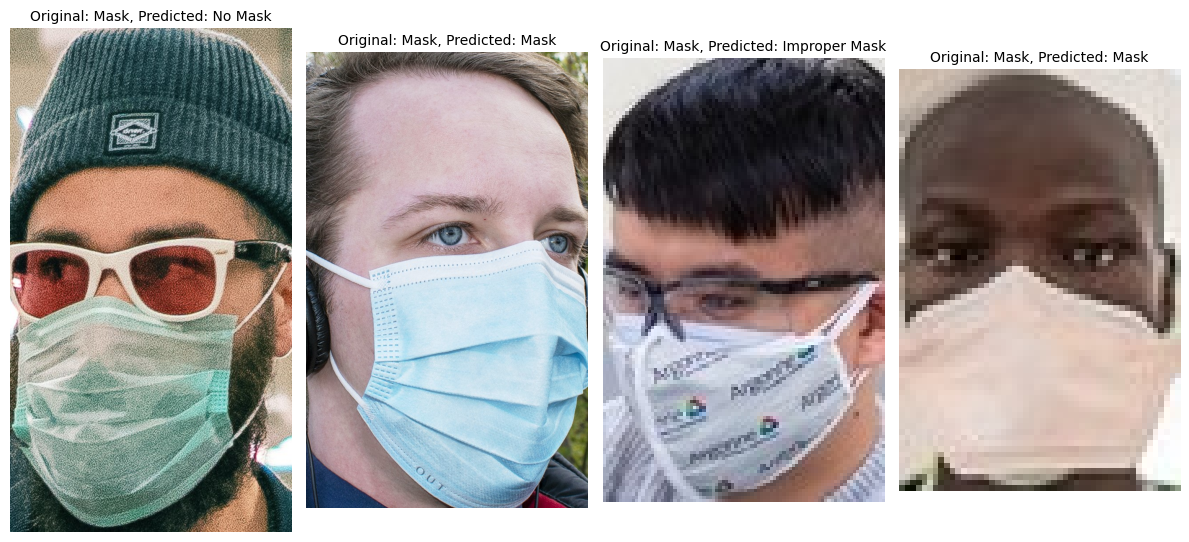

In [25]:
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
MaskDetection(path_to_testset, 'cnn')